We will consider the following five simple baseline models to provide foundational insights. These will serve as the baseline performance metrics that any subsequent machine learning models aim to beat.

1. **Global Mean Rating**:
This model predicts the global mean rating for all user-item pairs, serving as the most basic form of recommendation.

2. **User Mean Rating**:
For this model, the mean rating of each user is calculated and used to predict ratings for all items the user has not yet interacted with.

3. **Item Mean Rating**:
In contrast to the User Mean Rating, this model focuses on the mean rating of each item and uses it to predict ratings for all users.

4. **User-Item Mean Rating**:
This model takes a more nuanced approach by predicting a rating for a user-item pair as the average of the user's mean rating and the item's mean rating. The formula is:
$$prediction = \frac{User Mean Rating + Item Mean Rating}{2}$$

5. **Weighted Mean Ratings**:
This model employs a weighted average of the user mean and item mean ratings. The weight ( w ) can be adjusted based on domain understanding. The formula is :
$$prediction = w \times User Mean Rating + (1 - w) \times Item Mean Rating, \space where \space 0 \leq w \leq 1$$

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.insert(0, '..')

In [129]:
movies_df = pd.read_csv("../data/movies_metadata_after_eda.csv")
ratings_df = pd.read_csv("../data/ratings_small.csv")

In [130]:
train_df, test_df = train_test_split(ratings_df, test_size=0.3, random_state=42)

In [131]:
from sameer.services.ml_service.ml_utils import (
    calculate_user_item_mean_rating,
    calculate_weighted_mean_ratings,
    calculate_rmse,
)

test_df = calculate_user_item_mean_rating(train_df, test_df)
test_df, best_w, best_rmse = calculate_weighted_mean_ratings(test_df)
test_df.head()

,userId,movieId,rating,timestamp,global_mean_rating,user_mean_rating,item_mean_rating,user_item_mean_rating,weighted_mean_rating
0,128,1028,5.0,1049690908,3.540256,3.844444,3.836364,3.840404,3.841212
1,665,4736,1.0,1010197684,3.540256,3.294304,3.540256,3.417280,3.392685
2,120,4002,3.0,1167420604,3.540256,3.573684,3.318182,3.445933,3.471483
3,257,1274,4.0,1348544094,3.540256,3.801370,3.791667,3.796518,3.797489
4,468,6440,4.0,1296191715,3.540256,2.946196,3.900000,3.423098,3.327717


In [132]:
test_df["constant_rating"] = 2.5

user_stats = train_df.groupby("userId")["rating"].agg(["mean", "count"]).reset_index()

DAMPING_FACTOR = 0.2

test_df = test_df.merge(user_stats, on="userId", how="left")
test_df["damped_user_mean_rating"] = ((1 - DAMPING_FACTOR) * test_df["mean"]) + (
    DAMPING_FACTOR * test_df["global_mean_rating"][0]
)

rmse_damped_user_mean = calculate_rmse(
    test_df["rating"], test_df["damped_user_mean_rating"]
)

In [133]:
rmse_global_mean = calculate_rmse(test_df["rating"], test_df["global_mean_rating"])
rmse_user_mean = calculate_rmse(test_df["rating"], test_df["user_mean_rating"])
rmse_item_mean = calculate_rmse(test_df["rating"], test_df["item_mean_rating"])
rmse_user_item_mean = calculate_rmse(
    test_df["rating"], test_df["user_item_mean_rating"]
)
rmse_weighted_mean = calculate_rmse(test_df["rating"], test_df["weighted_mean_rating"])
rmse_constant = calculate_rmse(test_df["rating"], test_df["constant_rating"])
rmse_damped_user_mean = calculate_rmse(
    test_df["rating"], test_df["damped_user_mean_rating"]
)

In [134]:
print(f"RMSE for Global Mean Rating Model: {rmse_global_mean:.2f}")
print(f"RMSE for User Mean Rating Model: {rmse_user_mean:.2f}")
print(f"RMSE for Item Mean Rating Model: {rmse_item_mean:.2f}")
print(f"RMSE for User-Item Mean Rating Model: {rmse_user_item_mean:.2f}")
print(
    f"RMSE for Weighted Mean Rating Model: {best_rmse:.2f}, with setting the best weight is {best_w:.2f}"
)
print(f"RMSE for Constant Model: {rmse_constant:.2f}")
print(f"RMSE for Damped User-Mean Rating Model: {rmse_damped_user_mean:.2f}")

RMSE for Global Mean Rating Model: 1.06
RMSE for User Mean Rating Model: 0.96
RMSE for Item Mean Rating Model: 1.00
RMSE for User-Item Mean Rating Model: 0.92
RMSE for Weighted Mean Rating Model: 0.92, with setting the best weight is 0.60
RMSE for Constant Model: 1.49
RMSE for Damped User-Mean Rating Model: 0.96


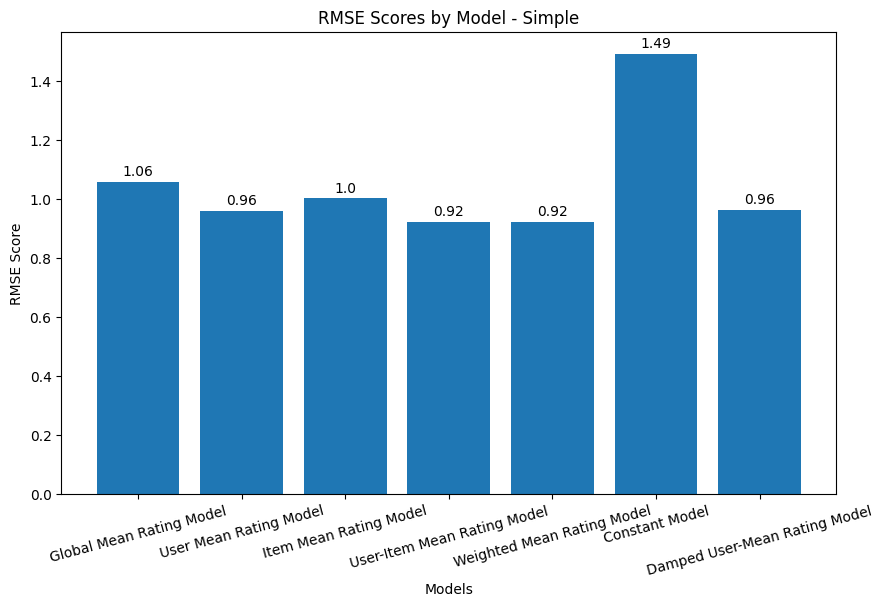

In [135]:
rmse_scores = {
    "Global Mean Rating Model": rmse_global_mean,
    "User Mean Rating Model": rmse_user_mean,
    "Item Mean Rating Model": rmse_item_mean,
    "User-Item Mean Rating Model": rmse_user_item_mean,
    "Weighted Mean Rating Model": best_rmse,
    "Constant Model": rmse_constant,
    "Damped User-Mean Rating Model": rmse_damped_user_mean,
}

plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_scores.keys(), rmse_scores.values())
plt.xlabel("Models")
plt.ylabel("RMSE Score")
plt.title("RMSE Scores by Model - Simple")
plt.xticks(rotation=15)

# Add the RMSE scores on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

In building a movie recommendation system, we start with simple models due to its importance in understanding how well we're doing. We found out that using both the average ratings from users and movies gets the best results, with a score (RMSE) of 0.92. This score shows how accurate our predictions are – the lower, the better. Models that only look at users or movies are okay, but not as good. The worst model is the one that always guesses the same rating, with a score of 1.49. These simple models help us know what to beat; any new, fancier model should score lower than 0.92 to be better.

We also look at more complex models because the simple ones don't consider what each user likes. Machine learning models can give more personalized suggestions, which is better for users.

In [136]:
from surprise import (
    Reader,
    Dataset,
    SVD,
    KNNWithZScore,
    NMF,
    accuracy,
    CoClustering,
)
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [137]:
reader = Reader(rating_scale=(1, 5))

train_data = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]], reader)
test_data = Dataset.load_from_df(test_df[["userId", "movieId", "rating"]], reader)

trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

algorithms = [SVD]
# algorithms = [SVD, KNNWithZScore, NMF, CoClustering]

param_grid = {
    SVD: {
        "n_factors": [125, 150, 175],
        "n_epochs": [25, 30, 35],
        "lr_all": [0.008, 0.01, 0.012],
        "reg_all": [0.15, 0.2, 0.25],
    },
    # KNNWithZScore: {
    #     "k": [35, 40, 45],
    #     "min_k": [1, 3, 5, 7],
    #     "sim_options": {
    #         "name": ["msd", "cosine", "pearson"],
    #         "user_based": [True, False],
    #     },
    # },
    # NMF: {
    #     "n_factors": [50, 100, 150],
    #     "n_epochs": [20, 25, 30],
    #     "reg_pu": [0.06, 0.08, 0.1],
    #     "reg_qi": [0.06, 0.08, 0.1],
    # },
    # CoClustering: {
    #     "n_cltr_u": [3, 5, 7],
    #     "n_cltr_i": [3, 5, 7],
    #     "n_epochs": [20, 30, 40],
    # },
}

In [138]:
best_models = {}
best_params = {}
best_rmse_scores = {}

for algo in algorithms:
    gs = GridSearchCV(algo, param_grid[algo], measures=["rmse"], cv=3, n_jobs=-1)
    gs.fit(train_data)

    best_models[algo.__name__] = gs.best_estimator["rmse"]
    best_params[algo.__name__] = gs.best_params["rmse"]
    best_rmse_scores[algo.__name__] = gs.best_score["rmse"]

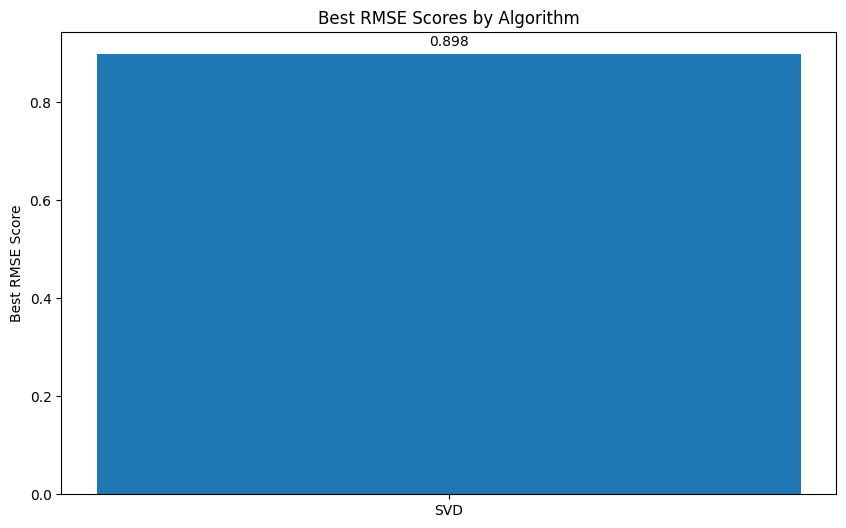

Best Model for SVD:
Best Parameters for SVD:
 {'n_factors': 150, 'n_epochs': 35, 'lr_all': 0.012, 'reg_all': 0.15}
Best RMSE score for SVD:
 0.89814692148855


In [139]:
plt.figure(figsize=(10, 6))
bars = plt.bar(best_rmse_scores.keys(), best_rmse_scores.values())
plt.ylabel("Best RMSE Score")
plt.title("Best RMSE Scores by Algorithm")

# Add the RMSE scores on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.show()

for algo_name, model in best_models.items():
    print(f"Best Model for {algo_name}:\n", model)
    print(f"Best Parameters for {algo_name}:\n", best_params[algo_name])
    print(f"Best RMSE score for {algo_name}:\n", best_rmse_scores[algo_name])

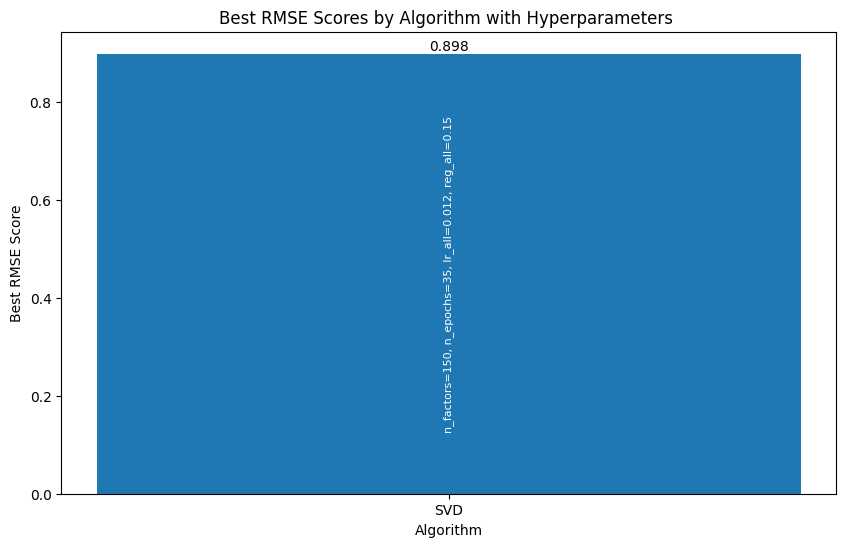

In [140]:
# Create a figure
plt.figure(figsize=(10, 6))

# Create a bar plot of the best RMSE scores
bars = plt.bar(range(len(best_rmse_scores)), list(best_rmse_scores.values()), align='center')

# Set the x-ticks to be the algorithm names
plt.xticks(range(len(best_rmse_scores)), list(best_rmse_scores.keys()))

# Add a title and labels
plt.title('Best RMSE Scores by Algorithm with Hyperparameters ')
plt.xlabel('Algorithm')
plt.ylabel('Best RMSE Score')

# Annotate the bars with the best hyperparameters
for bar, algo_name in zip(bars, best_rmse_scores.keys()):
    best_hyperparams = best_params[algo_name]
    annotation = ', '.join(f'{k}={v}' for k, v in best_hyperparams.items())
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, annotation, ha='center', va='center', rotation=90, color='white', fontsize=8)

    # Add RMSE score at the top of the bars
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{best_rmse_scores[algo_name]:.3f}', ha='center', va='bottom')

# Show the plot
plt.show()

In [141]:
best_algo = min(best_rmse_scores, key=best_rmse_scores.get)

print(f"Best Algorithm: {best_algo}")
print(f"Best Parameters: {best_params[best_algo]}")
print(f"Best RMSE score: {best_rmse_scores[best_algo]}")

Best Algorithm: SVD
Best Parameters: {'n_factors': 150, 'n_epochs': 35, 'lr_all': 0.012, 'reg_all': 0.15}
Best RMSE score: 0.89814692148855


## Conclusion

SVD: Achieved an RMSE score of `0.897`
KNNWithZScore: Registered an RMSE score of `0.929`
NMF: Posted an RMSE score of `1.002`

SVD outperformed the rest, so we will be going with it with the following parameters: `Best Parameters: {'n_factors': 150, 'n_epochs': 35, 'lr_all': 0.01, 'reg_all': 0.15}`

In [142]:
best_algo_name = min(best_rmse_scores, key=best_rmse_scores.get)
best_algo_model = best_models[best_algo_name]

best_algo_model.fit(trainset)

predictions = best_algo_model.test(testset)

rmse_score = accuracy.rmse(predictions)
mae_score = accuracy.mae(predictions)
fcp_score = accuracy.fcp(predictions)

print(f"Evaluation Metrics:")
print(f"RMSE score: {rmse_score}")
print(f"MAE score: {mae_score}")
print(f"FCP score: {fcp_score}")

predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(
    columns={"uid": "userId", "iid": "movieId", "r_ui": "actual", "est": "predicted"}
)
predictions_df["error"] = np.abs(predictions_df["actual"] - predictions_df["predicted"])


# Create the directory if it doesn't exist
os.makedirs("./dump", exist_ok=True)

# Save the DataFrame to a CSV file
predictions_df.to_csv("./dump/predictions.csv", index=False)

RMSE: 0.8853
MAE:  0.6818
FCP:  0.6600
Evaluation Metrics:
RMSE score: 0.8853284970459143
MAE score: 0.6818234132215633
FCP score: 0.6600070991677885


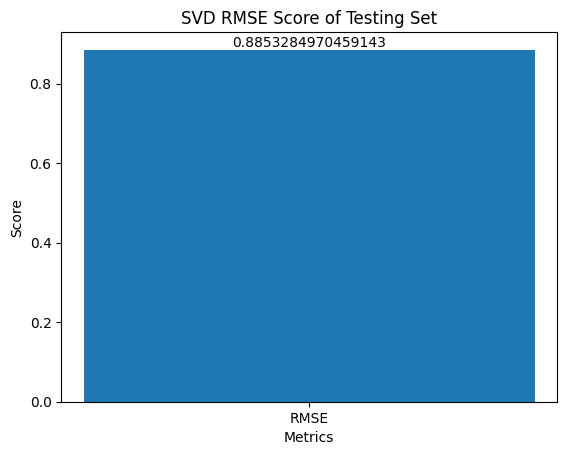

In [143]:
scores = [rmse_score,]
metrics = ['RMSE']

plt.bar(metrics, scores)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('SVD RMSE Score of Testing Set')

# Add the score values on top of the bars
for i in range(len(metrics)):
    plt.text(i, scores[i], str(scores[i]), ha='center', va='bottom')

plt.show()

In [144]:
import os

# Create the directory if it doesn't exist
os.makedirs("./dump", exist_ok=True)

# Save the DataFrame to a CSV file
predictions_df.to_csv("./dump/predictions.csv", index=False)

In [145]:
import pickle

with open(f"./pickels/best_svd_model.pkl", "wb") as f:
    pickle.dump(best_algo_model, f)

The machine learning model achieved an RMSE of 0.897 on training data and 0.8848 on test data, indicating robustness and good generalization. It outperformed baseline models (User-Item and Weighted Mean Rating Models with an RMSE of 0.92), demonstrating the effectiveness of a complex algorithm in the recommendation system. The model is suitable for real-world deployment due to its strong performance on unseen data.

Now for `Weighted Rating` which calcuates based on both the popularity and user ratings.

By blending these two factors, we aim to suggest movies that are both high-quality and widely liked.

Importantly, this method can also be combined with other recommendation techniques to create a more advanced, hybrid system. In this section, we calculate a weighted rating for each movie in the dataset. The steps are as follows:

- Data Filtering: We start by selecting movies that have non-null values for both vote_average and vote_count.

- Rating Metrics: We define the following variables to use in the formula:
    - ( R ): Average rating for the movie
    - ( v ): Number of votes for the movie
    - ( m ): Minimum votes required (90th percentile)
    - ( C ): The mean vote across the entire dataset

- Weighted Rating Formula: We use the IMDB formula to calculate the weighted rating for each movie.
$$Weighted Rating = \frac{R\times v + C \times m}{v+m}$$

- Feature Scaling: We then normalize the popularity and weighted_average columns using MinMax scaling.

A score is calculated for each movie as a weighted sum of the normalized weighted_average and popularity. Specifically, it's 40% weighted_average and 60% popularity.

In [146]:
R = movies_df["vote_average"]
v = movies_df["vote_count"]
m = movies_df["vote_count"].quantile(0.9)
C = movies_df["vote_average"].mean()
movies_df["weighted_average"] = (R * v + C * m) / (v + m)

In [147]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(movies_df[["popularity", "weighted_average"]])

weighted_df = pd.DataFrame(scaled, columns=["popularity", "weighted_average"])
weighted_df.index = movies_df["id"]

weighted_df["score"] = (
    weighted_df["weighted_average"] * 0.4 + weighted_df["popularity"] * 0.6
)

weighted_df_sorted = weighted_df.sort_values(by="score", ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
id,,,
211672,1.000000,0.574825,0.829930
297762,0.537613,0.734315,0.616294
321612,0.524675,0.655367,0.576952
177572,0.390602,0.856364,0.576907
680,0.257449,0.960073,0.538499
339403,0.416507,0.721434,0.538478
283995,0.338511,0.813503,0.528508
155,0.224968,0.962900,0.520141
210577,0.282748,0.875895,0.520007


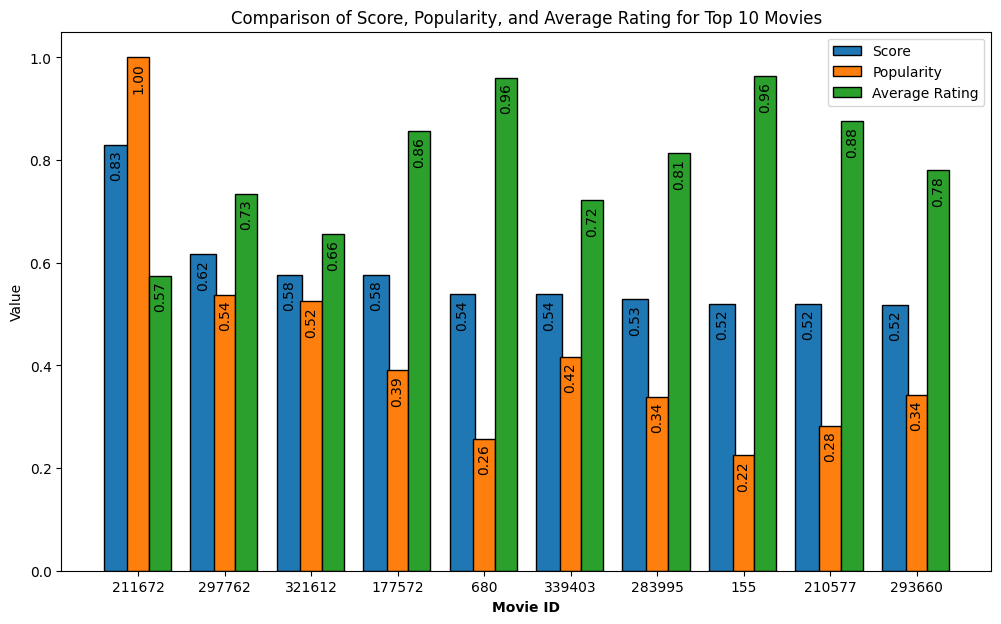

In [148]:
# Get the top 10 movies
top_10_movies = weighted_df_sorted.head(10)

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(top_10_movies))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the grouped bar chart
plt.figure(figsize=(12, 7))

# Create the bars
bars1 = plt.bar(r1, top_10_movies['score'], color='#1f77b4', width=bar_width + 0.05, edgecolor='black', label='Score')
bars2 = plt.bar(r2, top_10_movies['popularity'], color='#ff7f0e', width=bar_width, edgecolor='black', label='Popularity')
bars3 = plt.bar(r3, top_10_movies['weighted_average'], color='#2ca02c', width=bar_width, edgecolor='black', label='Average Rating')

# Function to add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height - 0.07,
                 '{:.2f}'.format(height), ha='center', va='bottom', rotation=90)

# Add labels to each bar
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Add labels and title
plt.xlabel('Movie ID', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(top_10_movies))], top_10_movies.index)
plt.ylabel('Value')
plt.title('Comparison of Score, Popularity, and Average Rating for Top 10 Movies')

plt.legend()
plt.show()

Now for content-based filtering

To find movies that closely match a user's preferred film, our recommendation model employs Cosine Similarity, a type of content-based filtering approach. This method calculates similarity scores for each pair of movies in our database by considering various attributes such as keywords, genre, cast, and director. These attributes, collectively termed as "content," help the model to quantify how similar two movies are. If the attributes closely match, the movies are considered similar. The model then sorts these calculated scores and recommends the top 10 movies most similar to the user's chosen film. The underlying idea is that if a user enjoys a particular movie, they are likely to appreciate similar ones as well.

In [149]:
movies_df["bag_of_words"].fillna("-", inplace=True)
movies_df["director"].fillna("-", inplace=True)

In [150]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words="english")
count_matrix = count.fit_transform(movies_df["bag_of_words"])

In [151]:
sim_mat = cosine_similarity(count_matrix, count_matrix)

In [152]:
movies_df = movies_df.reset_index()
indices = pd.Series(movies_df.index, index=movies_df["title"])

In [153]:
def get_recommendations(title, cosine_sim):
    # TODO: add fuzzy search to match the title
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    # Normalize the scores to a scale of 0 to 100%
    max_score = sim_scores[0][1]
    normalized_scores = ["{:.3f}".format((score / max_score) * 1) for _, score in sim_scores]

    # Create a DataFrame with the movie titles and normalized scores
    recommendations = pd.DataFrame({
        'Movie Title': movies_df["title"].iloc[movie_indices],
        'Similarity Score': normalized_scores
    })

    return recommendations

In [154]:
get_recommendations("The Dark Knight Rises", sim_mat)

,Movie Title,Similarity Score
12535,The Dark Knight,1.000
10164,Batman Begins,0.875
9265,Shiner,0.598
9828,Amongst Friends,0.530
7727,Mitchell,0.528
516,Romeo Is Bleeding,0.500
11405,The Prestige,0.500
24004,Quicksand,0.500
24945,Deadfall,0.500
40973,Sara,0.484


In [155]:
get_recommendations("Dune", sim_mat)

,Movie Title,Similarity Score
22798,Behind Enemy Lines,1.000
2524,Star Wars: Episode I - The Phantom Menace,0.894
8690,Gamera vs. Jiger,0.894
10166,Godzilla: Final Wars,0.894
18104,Prisoners of the Lost Universe,0.894
22701,Gamera vs. Viras,0.894
22815,Gamera vs. Guiron,0.894
25196,Jurassic World,0.894
28472,Gamera vs. Zigra,0.894
19410,Bells of Innocence,0.866


In [156]:
get_recommendations("The Lord of the Rings", sim_mat)

,Movie Title,Similarity Score
42477,Daishizen no Majū: Bagi,1.000
9645,Wizards,0.894
16446,The Return of the King,0.894
37536,The Life of Guskou Budori,0.866
16524,Cirque du Soleil: Varekai,0.816
16583,The Fern Flower,0.816
24329,How Wang-Fo Was Saved,0.816
28872,The Mascot,0.816
30169,My Love,0.816
32283,Monster High: Scaris City of Frights,0.816


In [157]:
from sameer.services.ml_service.ml_utils import load_pickle_model

model = load_pickle_model("./pickels/best_svd_model.pkl")

In [158]:
import random

In [159]:
import warnings

warnings.simplefilter("ignore")

In [160]:
from sameer.services.ml_service.ml_utils import hybrid_predicted_rating

for i in range(5):
    random_movie = random.choice(movies_df.index.tolist())
    random_user = random.choice(ratings_df["userId"].tolist())
    predicted_rating = hybrid_predicted_rating(
        userId=random_user,
        movieId=random_movie,
        model=model,
        similarity_matrix=sim_mat,
        movies_df=movies_df,
        weighted_df=weighted_df,
    )

    print(
        f"The predicted hybrid rating for userId={random_user} for movieId={random_movie} is: {predicted_rating}"
    )

The predicted hybrid rating for userId=23 for movieId=9177 is: 2.4746009347929308
The predicted hybrid rating for userId=450 for movieId=46000 is: 2.761038454912758
The predicted hybrid rating for userId=61 for movieId=13985 is: 2.3683418386468835
The predicted hybrid rating for userId=75 for movieId=3110 is: 2.232875794649182
The predicted hybrid rating for userId=548 for movieId=20101 is: 2.4357659172550923


In [161]:
random_user = random.choice(ratings_df["userId"].tolist())

In [162]:
random_user = random.choice(ratings_df["userId"].tolist())

In [163]:
import ast

movies_df["genres"] = movies_df["genres"].apply(lambda x: ast.literal_eval(x))

## Recommending Movies for Old Users

In this section, we will generate movie recommendations for users through our Hybrid Movie Recommender System. The system requires a user ID and follows a two-step process:

1. Collaborative Filtering: The system predicts movie ratings based on the user's past behavior using collaborative filtering techniques.

2. Content-Based Filtering: The system finds movies similar to the user's last watched movie using content-based filtering. It considers attributes such as keywords, genre, cast, and director to quantify the similarity between movies.

The Hybrid Movie Recommender System combines the recommendations from both collaborative filtering and content-based filtering. It assigns equal weight to each set of recommendations and generates a final list of the top 10 recommended movies. This hybrid approach aims to provide more accurate and personalized movie suggestions for old users.


In [164]:
weighted_df.to_csv("../data/weighted_df.csv", index=False)
ratings_df.to_csv("../data/ratings_df.csv", index=False)
movies_df.to_csv("../data/movies_df.csv", index=False)

In [277]:
def get_weighted_scores(movie_ids, weighted_df):
    """
    Fetches the weighted scores for a list of movie IDs.

    Parameters:
    - movie_ids (list): A list of movie IDs for which to fetch the weighted scores.
    - weighted_df (pandas.DataFrame): The weighted DataFrame containing weighted scores.

    Returns:
    - weighted_scores (dict): A dictionary mapping movie IDs to their corresponding weighted scores.
    """
    weighted_df = weighted_df.loc[~weighted_df.index.duplicated(keep="first")]

    weighted_scores = {
        movie_id: (
            weighted_df.loc[movie_id]["score"] if movie_id in weighted_df.index else 0
        )
        for movie_id in movie_ids
    }

    return weighted_scores


def show_movie_details(movie_ids, movies_df, n=10):
    """
    Display the details of recommended movies based on the specified movie IDs.

    Args:
        movie_ids (list): A list of movie IDs to filter the DataFrame.
        movies_df (pandas.DataFrame): The DataFrame containing movie details.
        n (int): The number of movie details to display.

    Raises:
        ValueError: If the movies_df DataFrame does not include the required columns.

    Returns:
        None
    """
    if movie_ids is None:
        print("No movie IDs provided.")
        return
    required_columns = ["id", "title", "year", "genres", "director"]
    if not all(column in movies_df.columns for column in required_columns):
        raise ValueError(
            f"movies_df must include the following columns: {required_columns}"
        )

    # Initialize an empty DataFrame to store the movie details
    details_df = pd.DataFrame(columns=required_columns)

    # Iterate over the movie_ids list until we have found n valid movies
    for movie_id in movie_ids:
        if len(details_df) >= n:
            break
        if movie_id in movies_df['id'].values:
            movie_details = movies_df.loc[movies_df['id'] == movie_id, required_columns]
            details_df = pd.concat([details_df, movie_details])

    # Sort the DataFrame by the 'year' column in descending order
    details_df.sort_values(by='year', ascending=False, inplace=True)

    # Reset the index of the DataFrame and drop the old index
    details_df.reset_index(drop=True, inplace=True)

    # Display the DataFrame
    display(details_df)


def get_user_rating_predictions(user_ratings):
    """
    Get predictions for user ratings.

    Args:
        user_ratings (pandas.DataFrame): DataFrame containing user ratings with columns "userId" and "movieId".

    Returns:
        list: List of tuples containing movieId and corresponding predicted ratings.
    """
    predictions = []
    for _, row in user_ratings.iterrows():
        pred = model.predict(row["userId"], row["movieId"]).est
        predictions.append((row["movieId"], pred))
    return predictions


def get_top_collab_movies(predictions, n):
    """
    Returns a list of the top n movies based on the predictions.

    Parameters:
    predictions (list): A list of tuples containing movie names and their corresponding prediction values.
    n (int): The number of top movies to return.

    Returns:
    list: A list of the top n movie names.

    """
    return [x[0] for x in sorted(predictions, key=lambda x: x[1], reverse=True)[:n]]


def get_similar_movies(last_watched_movieId, n):
    """
    Get a list of similar movies based on the last watched movie.

    Parameters:
    last_watched_movieId (int): The ID of the last watched movie.
    n (int): The number of similar movies to return.

    Returns:
    list: A list of movie IDs of similar movies.

    """
    if last_watched_movieId in movies_df["id"].values:
        watched_movie_idx = movies_df[movies_df["id"] == last_watched_movieId].index[0]
        similar_movies = list(enumerate(sim_mat[watched_movie_idx]))
        sorted_similar_movies = sorted(
            similar_movies, key=lambda x: x[1], reverse=True
        )[1 : n + 1]
        return [movies_df.iloc[i[0]]["id"] for i in sorted_similar_movies]
    else:
        print(f"Movie ID {last_watched_movieId} not found in movies_df.")
        return []


def combine_scores(collab_weighted_scores, content_weighted_scores):
    """
    Combines collaborative and content-based weighted scores for movies.

    Parameters:
    - collab_weighted_scores (dict): A dictionary containing movie IDs as keys and collaborative weighted scores as values.
    - content_weighted_scores (dict): A dictionary containing movie IDs as keys and content-based weighted scores as values.

    Returns:
    - combined_scores (dict): A dictionary containing movie IDs as keys and combined scores as values, where the combined score is calculated as the sum of 0.5 times the collaborative weighted score and 0.5 times the content-based weighted score.
    """
    combined_scores = {}
    for movie_id, score in collab_weighted_scores.items():
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + 0.5 * score
    for movie_id, score in content_weighted_scores.items():
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + 0.5 * score
    return combined_scores


def hybrid_recommendation(user_id, n=10):
    """
    Generates hybrid movie recommendations for a given user.

    Parameters:
        user_id (int): The ID of the user for whom recommendations are generated.
        n (int, optional): The number of recommendations to generate. Defaults to 10.

    Returns:
        list: A list of movie IDs representing the top recommended movies for the user.
    """
    user_ratings = ratings_df[ratings_df["userId"] == user_id]
    predictions = get_user_rating_predictions(user_ratings)
    top_collab_movies = get_top_collab_movies(predictions, n)
    last_watched_movieId = user_ratings.iloc[-1]["movieId"]
    top_content_movies = get_similar_movies(last_watched_movieId, n)
    collab_weighted_scores = get_weighted_scores(top_collab_movies, weighted_df)
    content_weighted_scores = get_weighted_scores(top_content_movies, weighted_df)
    combined_scores = combine_scores(collab_weighted_scores, content_weighted_scores)
    sorted_movies = sorted(
        combined_scores.keys(), key=lambda x: combined_scores[x], reverse=True
    )

    # Print the last few movies watched by the user
    last_watched_movies = user_ratings.sort_values(by="timestamp", ascending=False).head(n)["movieId"]
    print("Last watched movies by the user:")
    show_movie_details(last_watched_movies, movies_df, n)

    # Print the recommended movies
    print("\nRecommended movies for the user:")
    show_movie_details(sorted_movies[:n], movies_df, n)


user_id = 235
recommended_movies = hybrid_recommendation(user_id)


Movie ID 30825.0 not found in movies_df.
Last watched movies by the user:


,id,title,year,genres,director
0,4979,Windows on Monday,2006,[drama],ulrichköhler
1,4973,Under the Sand,2000,"[drama, mystery]",françoisozon
2,1479,"Clean, Shaven",1993,"[drama, crime]",lodgekerrigan
3,2605,Short Circuit,1986,"[comedy, family, sciencefiction]",johnbadham
4,222,Berlin: Symphony of a Great City,1927,"[documentary, history]",walterruttmann



Recommended movies for the user:


,id,title,year,genres,director
0,920,Cars,2006,"[animation, adventure, comedy]",johnlasseter
1,4880,Nichts als Gespenster,2006,"[comedy, drama]",martingypkens
2,4326,Herr Lehmann,2003,"[comedy, drama]",leanderhaußmann
3,318,The Million Dollar Hotel,2000,"[drama, thriller]",wimwenders
4,4973,Under the Sand,2000,"[drama, mystery]",françoisozon
5,4226,Shriek If You Know What I Did Last Friday the ...,2000,[comedy],johnblanchard
6,6187,Dry Cleaning,1997,[drama],annefontaine


## Recommending Movies for New Users

In this section, we explore strategies to recommend movies to new users who have no historical data. We use two different approaches to tackle this issue:

To address the 'cold start' problem, we recommend top-rated and recent movies to new users. This approach utilizes a DataFrame of movie IDs and their weighted scores to generate a list of top n movies from the last min_year years. The recommendations are sorted by a score that combines both popularity and user ratings. The function is flexible, allowing you to specify the number of recommendations and the time frame for recent movies.



In [291]:
from datetime import datetime

top_n=10
min_year = 7

def recommend_for_new_user_top_rating_movies(
    weighted_df, movies_df,
):
    """
    Recommend the top n movies for a new user based on weighted rating scores.

    Parameters:
    df (DataFrame): DataFrame containing movie IDs and their weighted scores.
    n (int): Number of top movies to recommend.

    Returns:
    DataFrame: Top n recommended movies for a new user.
    """
    current_year = datetime.now().year
    recent_movies_filter = movies_df["year"].fillna(0).astype(int) >= (
        current_year - min_year
    )
    recent_movies_df = movies_df[recent_movies_filter]

    merged_df = pd.merge(
        weighted_df, recent_movies_df[["id", "year"]], on="id", how="inner"
    )
    top_movies_df = merged_df.sort_values(by="score", ascending=False).head(top_n)

    return top_movies_df


top_movies = recommend_for_new_user_top_rating_movies(
    weighted_df, movies_df[["id", "year"]],
)
show_movie_details(top_movies["id"], movies_df, top_n)

,id,title,year,genres,director
0,297762,Wonder Woman,2017,"[action, adventure, fantasy]",pattyjenkins
1,321612,Beauty and the Beast,2017,"[family, fantasy, romance]",billcondon
2,339403,Baby Driver,2017,"[action, crime]",edgarwright
3,283995,Guardians of the Galaxy Vol. 2,2017,"[action, adventure, comedy]",jamesgunn
4,281338,War for the Planet of the Apes,2017,"[drama, sciencefiction, war]",mattreeves
5,166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017,"[adventure, action, fantasy]",joachimrønning
6,263115,Logan,2017,"[action, drama, sciencefiction]",jamesmangold
7,374720,Dunkirk,2017,"[action, drama, history]",christophernolan
8,406990,What Happened to Monday,2017,"[sciencefiction, thriller]",tommywirkola
9,419430,Get Out,2017,"[mystery, thriller, horror]",jordanpeele


# Another approach for the cold start problem

To address the 'cold start' problem for new users, we can recommend top-rated movies in various genres. This approach provides genre-specific lists of top movies from the last `min_year` years. By offering genre-specific recommendations, new users can immediately find movies aligned with their preferences.

the unique geners = ['mystery', 'action', 'comedy', 'foreign', 'war', 'tvmovie', 'fantasy', 'adventure', 'thriller', 'history', 'documentary', 'horror', 'sciencefiction', 'western', 'romance', 'family', 'animation', 'crime', 'drama', 'music']

In [292]:
from datetime import datetime


def recommend_for_new_user_by_genre(
    weighted_df,
    movies_df,
    target_genres,
    top_n=10,
    recent_years_threshold=5,
):
    """
    Recommend the top N movies for a new user based on weighted rating scores within specified genres,
    considering movies released within a defined recent year threshold.

    Parameters:
    weighted_scores_df (DataFrame): DataFrame containing movie IDs and their weighted scores.
    movies_details_df (DataFrame): DataFrame containing movie IDs, genres, and release years.
    target_genres (list): List of genres to consider for recommendations.
    top_n (int): Number of top movies to recommend for each genre.
    recent_years_threshold (int): Number of recent years to consider for movie recommendations.

    Returns:
    dict: Dictionary with genres as keys and DataFrames of top N recommended movies for each genre as values.
    """
    recommendations = {}
    current_year = datetime.now().year

    movies_details_df = movies_df.copy()
    movies_details_df["year"] = movies_details_df["year"].fillna(0).astype(int)

    recent_movies_df = movies_details_df[
        movies_details_df["year"] >= (current_year - recent_years_threshold)
    ]

    for genre in target_genres:
        genre_filtered_df = recent_movies_df[
            recent_movies_df["genres"].apply(
                lambda genres: genre in genres if genres else False
            )
        ]

        genre_with_scores_df = pd.merge(
            weighted_df, genre_filtered_df[["id", "year"]], on="id", how="inner"
        )

        top_movies_for_genre = genre_with_scores_df.sort_values(
            by="score", ascending=False
        ).head(top_n)

        recommendations[genre] = top_movies_for_genre

    return recommendations


genres_list = ["sciencefiction", "documentary", "comedy"]

top_movies_by_genre = recommend_for_new_user_by_genre(
    weighted_df, movies_df, genres_list, top_n=3, recent_years_threshold=10
)
for genre in genres_list:
    print(genre)
    show_movie_details(top_movies_by_genre[genre]["id"], movies_df)

sciencefiction


,id,title,year,genres,director
0,281338,War for the Planet of the Apes,2017,"[drama, sciencefiction, war]",mattreeves
1,271110,Captain America: Civil War,2016,"[adventure, action, sciencefiction]",anthonyrusso
2,118340,Guardians of the Galaxy,2014,"[action, sciencefiction, adventure]",jamesgunn


documentary


,id,title,year,genres,director
0,331781,Amy,2015,"[documentary, music]",asifkapadia
1,318224,Going Clear: Scientology and the Prison of Belief,2015,[documentary],alexgibney
2,293310,Citizenfour,2014,[documentary],laurapoitras


comedy


,id,title,year,genres,director
0,283995,Guardians of the Galaxy Vol. 2,2017,"[action, adventure, comedy]",jamesgunn
1,293660,Deadpool,2016,"[action, adventure, comedy]",timmiller
2,150540,Inside Out,2015,"[drama, comedy, animation]",petedocter
